In [1]:
# ======================
# CELL 1 — Import libs
# ======================

import os
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import cv2
from tqdm import tqdm


In [2]:

# ======================
# CELL 2 — Load CSVs
# ======================

import pandas as pd

# Define paths 
mass_train_csv = '/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/dataset/mass_case_description_train_set.csv'
mass_test_csv  = '/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/dataset/mass_case_description_test_set.csv'
calc_train_csv = '/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/dataset/calc_case_description_train_set.csv'
calc_test_csv  = '/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/dataset/calc_case_description_test_set.csv'

# Load CSVs
mass_train_df = pd.read_csv(mass_train_csv)
mass_test_df  = pd.read_csv(mass_test_csv)
calc_train_df = pd.read_csv(calc_train_csv)
calc_test_df  = pd.read_csv(calc_test_csv)

# confirmations
print("CSV files loaded:")
print("  mass_train:", mass_train_df.shape, "|", mass_train_csv)
print("  mass_test :", mass_test_df.shape,  "|", mass_test_csv)
print("  calc_train:", calc_train_df.shape, "|", calc_train_csv)
print("  calc_test :", calc_test_df.shape,  "|", calc_test_csv)

# Show preview from one (mass_train)
mass_train_df.head()


CSV files loaded:
  mass_train: (1318, 14) | /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/dataset/mass_case_description_train_set.csv
  mass_test : (378, 14) | /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/dataset/mass_case_description_test_set.csv
  calc_train: (1546, 14) | /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/dataset/calc_case_description_train_set.csv
  calc_test : (326, 14) | /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/dataset/calc_case_description_test_set.csv


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
# ======================
# CELL 3 — DICOM Loader
# ======================

import numpy as np
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def load_dicom_image(path, voi_lut=True, fix_monochrome=True, resize_to=(1024, 1024)):
    """
    Load a DICOM image, apply VOI LUT if necessary, fix monochrome inversion, and resize.

    Parameters:
        path (str): Path to the .dcm file
        voi_lut (bool): Whether to apply VOI LUT (brightness/contrast transformation)
        fix_monochrome (bool): Whether to fix MONOCHROME1 images
        resize_to (tuple): Target dimensions (width, height) to resize image to (w,h)

    Returns:
        numpy.ndarray: Processed image as 2D array (grayscale)
    """
    dicom = pydicom.dcmread(path)

    # brightness-contrast correction
    if voi_lut:
        image = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        image = dicom.pixel_array

    # fix inverted grayscale (MONOCHROME1)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        image = np.amax(image) - image

    # normalize to 0–1
    image = image.astype(np.float32)
    image -= np.min(image)
    if np.max(image) > 0:
        image /= np.max(image)

    #Resize with OpenCV (width x height)
    if resize_to:
        image = cv2.resize(image, resize_to, interpolation=cv2.INTER_AREA)

    return image


In [ ]:
# ======================
# CELL 4 — FULL PIPELINE
#  - Build DICOM header index (cached)
#  - Merge with CSV metadata
#   - Create balanced patient-level subset 
#   - Save manifests and simple 70/15/15 split
# ======================

import os, re, json
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
import pydicom

# --- Paths ------
PROJECT_ROOT   = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP")
RAW_DICOM_DIR  = PROJECT_ROOT / "dataset" / "raw_dicom"
PROCESSED_DIR  = PROJECT_ROOT / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

DICOM_INDEX_PATH     = PROCESSED_DIR / "dicom_header_index.parquet"
MERGED_MANIFEST_PATH = PROCESSED_DIR / "manifest_master.csv"
SUBSET_MANIFEST_PATH = PROCESSED_DIR / "manifest_subset.csv"
COVERAGE_PATH        = PROCESSED_DIR / "subset_coverage.csv"
SPLIT_PATH           = PROCESSED_DIR / "subset_split.csv"

# How many patients to target in total for the subset 
TARGET_PATIENTS = 350
RANDOM_SEED = 42

# ---------- Helpers --------
CASE_NAME_RE = re.compile(r'(Mass|Calc)-(Training|Test)_P_(\d{5})_([A-Za-z]+)_(CC|MLO)')

def pad_pid(x) -> str:
    if x is None:
        return None
    s = str(x).strip()
    if s.startswith("P_"):
        s = s[2:]
    s = re.sub(r"\D", "", s)
    if s == "":
        return None
    try:
        return f"P_{int(s):05d}"
    except Exception:
        return None

def norm_lat(x):
    if x is None:
        return np.nan
    x = str(x).strip().upper()
    if x in ("L", "LEFT"):
        return "L"
    if x in ("R", "RIGHT"):
        return "R"
    return np.nan

def norm_view(x):
    if x is None:
        return np.nan
    x = str(x).strip().upper()
    if "CC" in x:
        return "CC"
    if "MLO" in x:
        return "MLO"
    return np.nan

def is_full_image(p: Path) -> bool:
    s = str(p)
    if "full mammogram images" not in s:
        return False
    if p.name.startswith("._"):  
        return False
    return True

def parse_from_path(p: Path):
    m = CASE_NAME_RE.search(str(p))
    if not m:
        return None, None, None
    _, _, pid_num, lat_raw, view_raw = m.groups()
    patient_id = pad_pid(pid_num)
    laterality = norm_lat(lat_raw)
    view = norm_view(view_raw)
    return patient_id, laterality, view

def read_header_minimal(p: Path):
    """Read DICOM header without pixel data; fallback to path parsing."""
    pid = lat = view = None
    try:
        ds = pydicom.dcmread(str(p), stop_before_pixels=True, force=True)
        pid = pad_pid(getattr(ds, "PatientID", None))
        lat = norm_lat(getattr(ds, "ImageLaterality", None))
        view = norm_view(getattr(ds, "ViewPosition", None))
    except Exception:
        pass

    if not pid or pd.isna(lat) or pd.isna(view):
        pid2, lat2, view2 = parse_from_path(p)
        if not pid and pid2:
            pid = pid2
        if (lat is None or pd.isna(lat)) and lat2:
            lat = lat2
        if (view is None or pd.isna(view)) and view2:
            view = view2

    if pid and lat in ("L", "R") and view in ("CC", "MLO"):
        return {"dicom_path": str(p), "patient_id": pid, "laterality": lat, "view": view}
    return None

# ---------- Step 1: Discover and index DICOM headers (cached, with Parquet - - CSV fallback) ----------
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

DICOM_INDEX_PATH_PARQ = DICOM_INDEX_PATH
DICOM_INDEX_PATH_CSV  = DICOM_INDEX_PATH_PARQ.with_suffix(".csv") 

def _load_index_with_fallback():
    if DICOM_INDEX_PATH_PARQ.exists():
        try:
            return pd.read_parquet(DICOM_INDEX_PATH_PARQ)
        except Exception as e:
            print(f"Warning: failed to read Parquet cache ({e}). Trying CSV...")
    if DICOM_INDEX_PATH_CSV.exists():
        try:
            return pd.read_csv(DICOM_INDEX_PATH_CSV)
        except Exception as e:
            print(f"Warning: failed to read CSV cache ({e}).")
    return None

def _save_index_with_fallback(df: pd.DataFrame):
    try:
        df.to_parquet(DICOM_INDEX_PATH_PARQ, index=False)
        print(f"Saved DICOM index (Parquet): {len(df):,} rows -> {DICOM_INDEX_PATH_PARQ}")
    except Exception as e:
        print(f"Parquet save unavailable ({e}). Saving CSV instead...")
        df.to_csv(DICOM_INDEX_PATH_CSV, index=False)
        print(f"Saved DICOM index (CSV): {len(df):,} rows -> {DICOM_INDEX_PATH_CSV}")

dicom_idx = _load_index_with_fallback()
if dicom_idx is not None:
    print(f"Loaded cached DICOM index: {len(dicom_idx):,} rows")
else:
    all_files = [p for p in RAW_DICOM_DIR.rglob("*.dcm") if is_full_image(p)]
    total = len(all_files)
    print(f"Discovered {total:,} candidate DICOMs (full images). Building index with threads...")

    rows, done = [], 0
    report_every = max(200, total // 20)

    max_workers = min(16, os.cpu_count() or 8)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {ex.submit(read_header_minimal, p): p for p in all_files}
        for fut in as_completed(futures):
            rec = fut.result()
            if rec:
                rows.append(rec)
            done += 1
            if done % report_every == 0 or done == total:
                print(f"Indexed {done:,}/{total:,} ...")

    dicom_idx = pd.DataFrame(rows).drop_duplicates(
        subset=["patient_id", "laterality", "view", "dicom_path"]
    )

    _save_index_with_fallback(dicom_idx)



# ---------- Step 2: Clean CSV metadata and merge ----------
def tidy(df, lesion_type, split_csv):
    df = df.rename(columns={
        "left or right breast": "laterality",
        "image view": "view",
        "pathology": "pathology",
        "patient_id": "patient_id"
    }).copy()

    df["patient_id"] = df["patient_id"].apply(pad_pid)
    df["laterality"] = df["laterality"].apply(norm_lat)
    df["view"] = df["view"].apply(norm_view)
    df["pathology"] = df["pathology"].astype(str).str.strip().str.lower()
    df["lesion_type"] = lesion_type
    df["split_csv"] = split_csv

    return df[["patient_id", "laterality", "view", "pathology", "lesion_type", "split_csv"]].dropna()

csv_meta = pd.concat([
    tidy(mass_train_df, "mass", "train"),
    tidy(mass_test_df,  "mass", "test"),
    tidy(calc_train_df, "calc", "train"),
    tidy(calc_test_df,  "calc", "test"),
], ignore_index=True).drop_duplicates()

# Keep one DICOM per (patient, laterality, view) to avoid many-to-one duplicates
dicom_one_per_key = dicom_idx.sort_values("dicom_path").drop_duplicates(
    subset=["patient_id", "laterality", "view"], keep="first"
)

manifest_master = csv_meta.merge(
    dicom_one_per_key,
    on=["patient_id", "laterality", "view"],
    how="inner"
)

manifest_master.to_csv(MERGED_MANIFEST_PATH, index=False)
print(f"Master manifest saved: {len(manifest_master):,} rows -> {MERGED_MANIFEST_PATH}")

# ---------- Step 3: Build balanced patient-level subset (TARGET_PATIENTS) ----------

patient_tbl = (manifest_master
               .groupby(["lesion_type", "pathology", "patient_id"])
               .agg(views=("view", lambda s: set(s)),
                    lats=("laterality", lambda s: set(s)),
                    n_imgs=("dicom_path", "count"))
               .reset_index())
patient_tbl["score"] = patient_tbl["views"].apply(lambda s: 1 if {"CC","MLO"} <= s else 0) + \
                       patient_tbl["lats"].apply(lambda s: 1 if {"L","R"} <= s else 0)

# Determine per-bin target
bins = sorted(patient_tbl.groupby(["lesion_type","pathology"]).size().index.tolist())
per_bin = max(1, TARGET_PATIENTS // max(4, len(bins)))

rng = np.random.default_rng(RANDOM_SEED)
chosen_pids = []
for (lt, pa), g in patient_tbl.groupby(["lesion_type", "pathology"]):
    g = g.sample(frac=1.0, random_state=RANDOM_SEED).sort_values("score", ascending=False)
    take = min(per_bin, len(g))
    chosen_pids.extend(g.head(take)["patient_id"].tolist())

subset = manifest_master[manifest_master["patient_id"].isin(chosen_pids)].copy()
subset.to_csv(SUBSET_MANIFEST_PATH, index=False)

# Coverage table for appendix/report
coverage = (subset.groupby(["lesion_type","pathology","view","laterality"])
                  .size().reset_index(name="count")
                  .sort_values("count", ascending=False))
coverage.to_csv(COVERAGE_PATH, index=False)

print(f"Subset manifest saved: {len(subset):,} rows, patients: {subset['patient_id'].nunique():,} -> {SUBSET_MANIFEST_PATH}")
print(f"Coverage table saved -> {COVERAGE_PATH}")

#--- Step 4: Simple 70/15/15 patient-level split ---
split_rows = []
for (lt, pa), g in subset.groupby(["lesion_type","pathology"]):
    pts = sorted(g["patient_id"].unique())
    rng = np.random.default_rng(RANDOM_SEED)
    rng.shuffle(pts)
    n = len(pts)
    n_train = int(0.70 * n)
    n_val   = int(0.15 * n)
    train = set(pts[:n_train])
    val   = set(pts[n_train:n_train+n_val])
    test  = set(pts[n_train+n_val:])

    for pid in pts:
        split = "train" if pid in train else ("val" if pid in val else "test")
        split_rows.append({"patient_id": pid, "lesion_type": lt, "pathology": pa, "split": split})

split_df = pd.DataFrame(split_rows)
split_df.to_csv(SPLIT_PATH, index=False)

print(f"Patient split saved -> {SPLIT_PATH}")
print(split_df["split"].value_counts().to_string())



In [ ]:
# ======================
# CELL 5 — Patch extraction 
# ======================

import os
import csv
from pathlib import Path

import numpy as np
import pandas as pd
import cv2

# 1) Paths
PROJECT_ROOT   = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP")
PROCESSED_DIR  = PROJECT_ROOT / "processed"
PATCH_ROOT     = PROCESSED_DIR / "patches"
PATCH_ROOT.mkdir(parents=True, exist_ok=True)

MANIFEST_SUBSET = PROCESSED_DIR / "manifest_subset.csv"
SPLIT_CSV       = PROCESSED_DIR / "subset_split.csv"
PATCH_MANIFEST  = PROCESSED_DIR / "patch_manifest.csv" 

# 2) Hyperparameters
PATCH_SIZE = 64
STRIDE     = 32
RESIZE_TO  = (1024, 1024)   
DEV_LIMIT  = None          

# 3) Load manifests and merge split info (patient-level)
subset_df = pd.read_csv(MANIFEST_SUBSET)
split_df  = pd.read_csv(SPLIT_CSV)


subset_df["patient_id"] = subset_df["patient_id"].astype(str).str.strip()
split_df["patient_id"]  = split_df["patient_id"].astype(str).str.strip()

df = subset_df.merge(split_df[["patient_id","split"]], on="patient_id", how="inner")

# Label mapping from pathology
def label_from_pathology(x: str):
    x = str(x).strip().lower()
    if x == "malignant":
        return "malignant"
    elif x == "benign":
        return "benign"
    return "unknown"

df["label"] = df["pathology"].apply(label_from_pathology)
df = df[df["label"].isin(["benign","malignant"])].copy()

if DEV_LIMIT is not None:
    df = df.head(int(DEV_LIMIT)).copy()

print("Images to patch:", len(df))

# 4) Utilities
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def save_patch(img_patch: np.ndarray, out_path: Path):
    """
    Save a [0..1] float32 grayscale patch as 8-bit PNG.
    """
    im = np.clip(img_patch * 255.0, 0, 255).astype(np.uint8)
    cv2.imwrite(str(out_path), im)

def sliding_windows(image: np.ndarray, patch_size: int, stride: int):
    """
    Yield (i, j, patch) for top-left coordinate (i, j).
    Image is assumed to be 2D, size RESIZE_TO.
    """
    H, W = image.shape[:2]
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            yield i, j, image[i:i+patch_size, j:j+patch_size]

def append_patch_rows(rows):
    """
    Append rows (list of dicts) to PATCH_MANIFEST as CSV.
    Creates header on first write.
    """
    new_file = not PATCH_MANIFEST.exists()
    with open(PATCH_MANIFEST, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=[
            "patch_id",
            "patient_id",
            "split",
            "label",
            "lesion_type",
            "view",
            "laterality",
            "source_path",
            "patch_path",
            "i",
            "j"
        ])
        if new_file:
            writer.writeheader()
        for r in rows:
            writer.writerow(r)

# 5)Main loop
processed_images = 0
saved_patches = 0
skipped_patches = 0

for idx, row in df.iterrows():
    dcm_path    = Path(row["dicom_path"])
    patient_id  = row["patient_id"]
    split       = row["split"]
    label       = row["label"]
    lesion_type = row.get("lesion_type", "")
    view        = row.get("view", "")
    laterality  = row.get("laterality", "")

    # Output directory for this label/split
    out_dir = PATCH_ROOT / split / label / patient_id
    ensure_dir(out_dir)

    # Load DICOM as grayscale 
    try:
        img = load_dicom_image(str(dcm_path), resize_to=RESIZE_TO)
    except Exception as e:
        print("Failed to read:", dcm_path, e)
        continue

    rows_to_append = []
    patches_this_image = 0

    for i, j, patch in sliding_windows(img, PATCH_SIZE, STRIDE):
        # Build a deterministic filename
        patch_id = f"{patient_id}_{view}_{laterality}_{i:04d}_{j:04d}"
        out_path = out_dir / f"{patch_id}.png"

        if out_path.exists():
            skipped_patches += 1
            continue

        save_patch(patch, out_path)

        rows_to_append.append({
            "patch_id": patch_id,
            "patient_id": patient_id,
            "split": split,
            "label": label,
            "lesion_type": lesion_type,
            "view": view,
            "laterality": laterality,
            "source_path": str(dcm_path),
            "patch_path": str(out_path),
            "i": i,
            "j": j
        })
        saved_patches += 1
        patches_this_image += 1

    if rows_to_append:
        append_patch_rows(rows_to_append)

    processed_images += 1
    if processed_images % 10 == 0:
        print(f"Processed images: {processed_images} | saved patches: {saved_patches} | skipped: {skipped_patches}")

print("Done.")
print("Total images processed:", processed_images)
print("Total patches saved:", saved_patches)
print("Total patches skipped (already existed):", skipped_patches)
print("Patch manifest:", PATCH_MANIFEST)


In [ ]:
# ======================
# CELL 5.1 — Patch sanity checks
# ======================

import pandas as pd
from pathlib import Path

PROJECT_ROOT  = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP")
PROCESSED_DIR = PROJECT_ROOT / "processed"

PM_PATH   = PROCESSED_DIR / "patch_manifest.csv"
SUBSET_CV = PROCESSED_DIR / "subset_coverage.csv"

pm = pd.read_csv(PM_PATH)

print("Total patches:", len(pm))
print("\nBy split:")
print(pm.groupby("split").size())

print("\nBy label overall:")
print(pm.groupby("label").size())

print("\nBy split × label:")
print(pm.groupby(["split","label"]).size())

print("\nBy lesion_type × label (top 8):")
print(pm.groupby(["lesion_type","label"]).size().sort_values(ascending=False).head(8))


pm.head()


In [3]:
# ======================
# CELL 6 — tf.data input pipeline
# ======================

import os
import tensorflow as tf
import pandas as pd
import numpy as np

# Paths
PROJECT_ROOT  = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP"
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "processed")
PM_PATH       = os.path.join(PROCESSED_DIR, "patch_manifest.csv")

# Load manifest
pm = pd.read_csv(PM_PATH)

# only benign/malignant
pm = pm[pm["label"].isin(["benign","malignant"])].copy()

#Encode labels to 0/1
label_map = {"benign": 0, "malignant": 1}
pm["y"] = pm["label"].map(label_map).astype(np.int32)

# Split dataframes
train_df = pm[pm["split"] == "train"].reset_index(drop=True)
val_df   = pm[pm["split"] == "val"].reset_index(drop=True)
test_df  = pm[pm["split"] == "test"].reset_index(drop=True)

print("Patches per split:", {k: v for k, v in pm.groupby('split').size().items()})
print("Class balance (train):", train_df['y'].value_counts().to_dict())

def compute_class_weights(df):
    counts = df['y'].value_counts().to_dict()
    total  = sum(counts.values())
    weights = {cls: total/(len(counts)*cnt) for cls, cnt in counts.items()}
    return weights

class_weights = compute_class_weights(train_df)
print("Class weights:", class_weights)

# Data params
IMG_SIZE   = 64           
BATCH_SIZE = 256
AUTOTUNE   = tf.data.AUTOTUNE

def df_to_ds(df: pd.DataFrame, shuffle=False, seed=42):
    paths = df["patch_path"].astype(str).tolist()
    ys    = df["y"].astype(np.int32).tolist()
    ds = tf.data.Dataset.from_tensor_slices((paths, ys))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=seed, reshuffle_each_iteration=True)
    return ds

def decode_png(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=1, dtype=tf.uint8)      
    img = tf.image.convert_image_dtype(img, tf.float32)        
    return img

@tf.function
def preprocess_train(path, label):
    img = decode_png(path)
    # Basic augments
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    img = tf.image.random_contrast(img, 0.95, 1.05)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, tf.cast(label, tf.int32)

@tf.function
def preprocess_eval(path, label):
    img = decode_png(path)
    return img, tf.cast(label, tf.int32)

def make_pipeline(df, training=False, batch_size=BATCH_SIZE):
    ds = df_to_ds(df, shuffle=training)
    map_fn = preprocess_train if training else preprocess_eval
    ds = ds.map(map_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_pipeline(train_df, training=True)
val_ds   = make_pipeline(val_df, training=False)
test_ds  = make_pipeline(test_df, training=False)

# Peek one batch
for x, y in train_ds.take(1):
    print("Batch shapes:", x.shape, y.shape, "dtype:", x.dtype, y.dtype)


2025-09-13 00:53:37.801691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Patches per split: {'test': 96100, 'train': 360375, 'val': 82646}
Class balance (train): {0: 190278, 1: 170097}
Class weights: {0: 0.946969696969697, 1: 1.0593220338983051}


2025-09-13 00:53:51.826871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [360375]
	 [[{{node Placeholder/_0}}]]
2025-09-13 00:53:51.827270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [360375]
	 [[{{node Placeholder/_0}}]]


Batch shapes: (256, 64, 64, 1) (256,) dtype: <dtype: 'float32'> <dtype: 'int32'>


In [4]:
# ======================
# CELL 7 — Baseline CNN
# ======================
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

PROJECT_ROOT  = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP"
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "processed")
MODELS_DIR    = os.path.join(PROCESSED_DIR, "models")
FIG_DIR       = os.path.join(PROCESSED_DIR, "figures")
LOGS_DIR      = os.path.join(PROCESSED_DIR, "logs")
for d in (MODELS_DIR, FIG_DIR, LOGS_DIR):
    os.makedirs(d, exist_ok=True)

INPUT_SHAPE = (64, 64, 1)

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    return x

inputs = keras.Input(shape=INPUT_SHAPE)
x = inputs
x = conv_block(x, 32)
x = conv_block(x, 64)
x = conv_block(x, 128)
x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs, name="baseline_cnn")
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ],
)


Model: "baseline_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        288       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)       

In [ ]:
# ======================
# CELL 8 — RESUME TRAINING (original cell 8 )
# ======================
import os, pandas as pd, pathlib
from tensorflow import keras
import tensorflow as tf

processed_root = None
for vol in pathlib.Path("/Volumes").glob("DUAL DRIVE*"):
    cand = vol / "Azmina_MammoMind_FYP" / "processed"
    if cand.exists():
        processed_root = cand
        break
if processed_root is None:
    cand = pathlib.Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed")
    if cand.exists():
        processed_root = cand
assert processed_root is not None, "processed/ not found under /Volumes/DUAL DRIVE*/Azmina_MammoMind_FYP"

MODELS_DIR = processed_root / "models"
LOGS_DIR   = processed_root / "logs"
BACKUP_DIR = processed_root / "backup"   # for BackupAndRestore
MODELS_DIR.mkdir(parents=True, exist_ok=True)
LOGS_DIR.mkdir(parents=True, exist_ok=True)
BACKUP_DIR.mkdir(parents=True, exist_ok=True)

ckpt_path = MODELS_DIR / "baseline_cnn.best.h5"
hist_path = LOGS_DIR / "baseline_history.csv"
step_ckpt_path = MODELS_DIR / "baseline_step.ckpt"  # mid-epoch safety

print("[paths] models:", MODELS_DIR)
print("[paths] logs  :", LOGS_DIR)

# 1)Count how many epochs are already logged
epochs_done = 0
if hist_path.exists():
    try:
        hist = pd.read_csv(hist_path)
        epochs_done = int(hist["epoch"].iloc[-1]) + 1 if "epoch" in hist.columns else len(hist)
    except Exception as e:
        print("[warn] can't read history yet:", e)
print(f"[resume] epochs already logged: {epochs_done}")

# 2) Load best checkpoint if present
if ckpt_path.exists():
    model.load_weights(str(ckpt_path))
    print(f"[resume] loaded best checkpoint: {ckpt_path}")
else:
    print("[resume] no best checkpoint yet; starting from current weights")

# 3) Callbacks
callbacks = [
    # Save the best (by val_auc)
    keras.callbacks.ModelCheckpoint(
        str(ckpt_path), monitor="val_auc", mode="max", save_best_only=True, verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=str(step_ckpt_path),
        save_weights_only=True,
        save_freq=1000,          #
        verbose=0,
    ),
    # Write/append training log CSV (written at end of each epoch)
    keras.callbacks.CSVLogger(str(hist_path), append=True),
    # Stop early when val_auc plateaus
    keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1
    ),
    #Reduce LR on plateaus (helps convergence)
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-5, verbose=1
    ),
    keras.callbacks.BackupAndRestore(backup_dir=str(BACKUP_DIR), save_freq="epoch"),
]

#tf.config.threading.set_intra_op_parallelism_threads(2)

EPOCHS_MAX = 25
print(f"[resume] continuing from epoch {epochs_done} to {EPOCHS_MAX}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=epochs_done,   
    epochs=EPOCHS_MAX,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1,
)


In [ ]:
#cell 8 continuation

import os, pandas as pd
from tensorflow import keras

MODELS_DIR = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models"
LOGS_DIR   = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/logs"

ckpt_path = os.path.join(MODELS_DIR, "baseline_cnn.best.h5")
hist_path = os.path.join(LOGS_DIR, "baseline_history.csv")

# 1) How many epochs are already done
epochs_done = 0
if os.path.exists(hist_path):
    hist = pd.read_csv(hist_path)
    if len(hist) > 0:
        if "epoch" in hist.columns:
            epochs_done = int(hist["epoch"].iloc[-1]) + 1
        else:
            epochs_done = len(hist)
print(f"[resume] epochs already logged: {epochs_done}")

# 2) Load the best checkpoint so far
if os.path.exists(ckpt_path):
    model.load_weights(ckpt_path)
    print(f"[resume] loaded best checkpoint: {ckpt_path}")
else:
    print("[resume] no checkpoint found, starting from current weights")

# 3) Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.CSVLogger(hist_path, append=True),
]

EPOCHS_MAX = 25
print(f"[resume] continuing from epoch {epochs_done} to {EPOCHS_MAX}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=epochs_done,   
    epochs=EPOCHS_MAX,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1,
)



In [ ]:
#cell 8 2nd continuation 

import os, pandas as pd
from tensorflow import keras

MODELS_DIR = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models"
LOGS_DIR   = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/logs"

ckpt_path = os.path.join(MODELS_DIR, "baseline_cnn.best.h5")
hist_path = os.path.join(LOGS_DIR, "baseline_history.csv")

# --- Figure out where training stopped ---
epochs_done = 0
if os.path.exists(hist_path):
    hist = pd.read_csv(hist_path)
    if len(hist) > 0:
        if "epoch" in hist.columns:
            epochs_done = int(hist["epoch"].iloc[-1]) + 1
        else:
            epochs_done = len(hist)
print(f"[resume] epochs already logged in CSV: {epochs_done}")

# --- Load last/best weights ---
if os.path.exists(ckpt_path):
    model.load_weights(ckpt_path)
    print(f"[resume] loaded best checkpoint: {ckpt_path}")
else:
    print("[resume] no checkpoint found, starting fresh")

# --- Callbacks ---
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.CSVLogger(hist_path, append=True),
]

EPOCHS_MAX = 25
print(f"[resume] continuing from epoch {epochs_done} to {EPOCHS_MAX}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=epochs_done,  
    epochs=EPOCHS_MAX,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1,
)


In [ ]:
# ===== Cell 9: Evaluate best baseline model on test set =====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

MODELS_DIR = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models"
LOGS_DIR   = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/logs"
EVAL_DIR   = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_baseline"
os.makedirs(EVAL_DIR, exist_ok=True)

ckpt_path  = os.path.join(MODELS_DIR, "baseline_cnn.best.h5")
hist_path  = os.path.join(LOGS_DIR, "baseline_history.csv")

# 1) Load best weights
model.load_weights(ckpt_path)
print("Loaded checkpoint:", ckpt_path)

# 2) Evaluate with Keras for quick metrics
eval_res = model.evaluate(test_ds, verbose=1, return_dict=True)
print("Keras evaluate:", eval_res)

# 3) Get probabilities and labels for curves and CM
y_prob = model.predict(test_ds, verbose=1).ravel()
y_true = np.concatenate([y for _, y in test_ds], axis=0).astype(int)

# 4) Threshold at 0.5 for confusion matrix
y_pred = (y_prob >= 0.5).astype(int)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], lw=1, linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Baseline CNN")
plt.legend(loc="lower right")
plt.tight_layout()
roc_path = os.path.join(EVAL_DIR, "roc_curve.png")
plt.savefig(roc_path, dpi=150)
plt.close()
print("Saved:", roc_path)

# PR curve
prec, rec, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

plt.figure()
plt.plot(rec, prec, lw=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Baseline CNN")
plt.legend(loc="lower left")
plt.tight_layout()
pr_path = os.path.join(EVAL_DIR, "pr_curve.png")
plt.savefig(pr_path, dpi=150)
plt.close()
print("Saved:", pr_path)

# Confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["benign","malignant"], output_dict=True)

# Save CM as figure
plt.figure()
im = plt.imshow(cm, cmap="Blues")
plt.colorbar(im)
plt.title("Confusion Matrix – Baseline CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha="center", va="center")
plt.tight_layout()
cm_path = os.path.join(EVAL_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=150)
plt.close()
print("Saved:", cm_path)

# 5) Save metrics summary
summary = {
    "accuracy": eval_res.get("accuracy", np.nan),
    "auc": eval_res.get("auc", np.nan),
    "precision": eval_res.get("precision", np.nan),
    "recall": eval_res.get("recall", np.nan),
    "roc_auc": float(roc_auc),
    "avg_precision": float(ap),
    "tn": int(cm[0,0]),
    "fp": int(cm[0,1]),
    "fn": int(cm[1,0]),
    "tp": int(cm[1,1]),
}
pd.DataFrame([summary]).to_csv(os.path.join(EVAL_DIR, "metrics_summary.csv"), index=False)
pd.DataFrame(report).to_csv(os.path.join(EVAL_DIR, "classification_report.csv"))

#store raw predictions for appendix
pred_df = pd.DataFrame({"y_true": y_true, "y_prob": y_prob, "y_pred": y_pred})
pred_df.to_csv(os.path.join(EVAL_DIR, "test_predictions.csv"), index=False)

print("All evaluation artifacts saved to:", EVAL_DIR)


In [4]:
# ===== Cell 10: Attention CNN (Squeeze-and-Excitation, Resume-Safe) =====
import os, pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Paths (separate from baseline so nothing will get overwritten)
MODELS_DIR = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models"
LOGS_DIR   = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/logs"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

ATTN_CKPT = os.path.join(MODELS_DIR, "attention_cnn.best.h5")
ATTN_CSV  = os.path.join(LOGS_DIR, "attention_history.csv")

# 1) Define SE block
def se_block(x, reduction=16, name=None):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Dense(max(c // reduction, 8), activation="relu")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    s = layers.Reshape((1,1,c))(s)
    return layers.Multiply()([x, s])

# 2) Build Attention CNN
def build_attention_cnn(input_shape=(64,64,1)):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.15)(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.20)(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Head
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = se_block(x, reduction=8)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.30)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="attention_se_cnn")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model

# 3) Instantiate model
attn_model = build_attention_cnn(input_shape=(64,64,1))
attn_model.summary()

# 4)resume logic: how many epochs already logged
epochs_done = 0
if os.path.exists(ATTN_CSV):
    try:
        hist = pd.read_csv(ATTN_CSV)
        if len(hist) > 0:
            if "epoch" in hist.columns:
                epochs_done = int(hist["epoch"].iloc[-1]) + 1
            else:
                epochs_done = len(hist)
    except Exception as e:
        print("[warn] could not read history CSV:", e)

print(f"[resume] epochs already logged: {epochs_done}")

# 5) Load best checkpoint if available
if os.path.exists(ATTN_CKPT):
    attn_model.load_weights(ATTN_CKPT)
    print(f"[resume] loaded checkpoint: {ATTN_CKPT}")
else:
    print("[resume] no checkpoint found, starting fresh")

# 6)Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(ATTN_CKPT, monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=5e-5, verbose=1),
    keras.callbacks.CSVLogger(ATTN_CSV, append=True),
]

# 7)Train / Continue
EPOCHS_MAX = 25
print(f"[resume] continuing from epoch {epochs_done} to {EPOCHS_MAX}")

history_attn = attn_model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=epochs_done,
    epochs=EPOCHS_MAX,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1,
)


Model: "attention_se_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 64, 64, 32)   0           ['batch_normalizat

2025-09-12 09:22:56.769438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [360375]
	 [[{{node Placeholder/_1}}]]
2025-09-12 09:22:56.769860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype float and shape [2]
	 [[{{node Placeholder/_15}}]]


Epoch 21/25
1408/1408 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5354 - auc: 0.5362 - precision: 0.5112 - recall: 0.3563

2025-09-12 09:59:49.285756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [82646]
	 [[{{node Placeholder/_1}}]]
2025-09-12 09:59:49.286170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [82646]
	 [[{{node Placeholder/_1}}]]



Epoch 21: val_auc improved from -inf to 0.52958, saving model to /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models/attention_cnn.best.h5
1408/1408 [==============================] - 2318s 2s/step - loss: 0.6897 - accuracy: 0.5354 - auc: 0.5362 - precision: 0.5112 - recall: 0.3563 - val_loss: 0.6876 - val_accuracy: 0.5427 - val_auc: 0.5296 - val_precision: 0.5180 - val_recall: 0.2428 - lr: 0.0010
Epoch 22/25
1408/1408 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5360 - auc: 0.5367 - precision: 0.5119 - recall: 0.3649
Epoch 22: val_auc improved from 0.52958 to 0.53367, saving model to /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models/attention_cnn.best.h5
1408/1408 [==============================] - 2448s 2s/step - loss: 0.6894 - accuracy: 0.5360 - auc: 0.5367 - precision: 0.5119 - recall: 0.3649 - val_loss: 0.6883 - val_accuracy: 0.5393 - val_auc: 0.5337 - val_precision: 0.5066 - val_recall: 0.3640 - lr: 0.0010
Epoch 23/25
1408/1408 [=========

In [3]:
#cell 10 continuation

import os, pandas as pd

MODELS_DIR = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models"
LOGS_DIR   = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/logs"
ATTN_CKPT  = os.path.join(MODELS_DIR, "attention_cnn.best.h5")
ATTN_CSV   = os.path.join(LOGS_DIR, "attention_history.csv")

print("Checkpoint exists? ", os.path.exists(ATTN_CKPT))
print("History exists?    ", os.path.exists(ATTN_CSV))

epochs_done = 0
if os.path.exists(ATTN_CSV):
    try:
        hist = pd.read_csv(ATTN_CSV)
        if "epoch" in hist.columns:
            epochs_done = int(hist["epoch"].max()) + 1
        else:
            epochs_done = len(hist)
    except Exception as e:
        print("CSV read warning:", e)
print("Will resume from epoch:", epochs_done, "→", "Epoch {}/25".format(max(epochs_done,1)))


Checkpoint exists?  True
History exists?     True
Will resume from epoch: 20 → Epoch 20/25


In [5]:
# ===== Cell 11: Evaluate Attention CNN on Test Set =====
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras

# Paths
MODELS_DIR = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models"
LOGS_DIR   = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/logs"
EVAL_DIR   = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention"
os.makedirs(EVAL_DIR, exist_ok=True)

ATTN_CKPT  = os.path.join(MODELS_DIR, "attention_cnn.best.h5")
ATTN_JSON  = os.path.join(LOGS_DIR, "attention_test_metrics.json")

# 1)Load best attention weights
attn_model.load_weights(ATTN_CKPT)
print("Loaded attention checkpoint:", ATTN_CKPT)

# 2)quick Keras evaluation
eval_res = attn_model.evaluate(test_ds, verbose=1, return_dict=True)
print("Keras evaluate:", eval_res)

# 3) Full predictions for curves & confusion matrix
y_prob = attn_model.predict(test_ds, verbose=1).ravel()
y_true = np.concatenate([y for _, y in test_ds], axis=0).astype(int)
y_pred = (y_prob >= 0.5).astype(int)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], lw=1, linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Attention CNN")
plt.legend(loc="lower right")
plt.tight_layout()
roc_path = os.path.join(EVAL_DIR, "roc_curve_attention.png")
plt.savefig(roc_path, dpi=150)
plt.close()
print("Saved:", roc_path)

# PR
prec, rec, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)
plt.figure()
plt.plot(rec, prec, lw=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Attention CNN")
plt.legend(loc="lower left")
plt.tight_layout()
pr_path = os.path.join(EVAL_DIR, "pr_curve_attention.png")
plt.savefig(pr_path, dpi=150)
plt.close()
print("Saved:", pr_path)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
im = plt.imshow(cm, cmap="Blues")
plt.colorbar(im)
plt.title("Confusion Matrix – Attention CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha="center", va="center")
plt.tight_layout()
cm_path = os.path.join(EVAL_DIR, "confusion_matrix_attention.png")
plt.savefig(cm_path, dpi=150)
plt.close()
print("Saved:", cm_path)

# Classification report
report = classification_report(y_true, y_pred, target_names=["benign","malignant"], output_dict=True)

# 4) Save metrics
summary = {
    "accuracy": float(eval_res.get("accuracy", np.nan)),
    "auc": float(eval_res.get("auc", np.nan)),
    "precision": float(eval_res.get("precision", np.nan)),
    "recall": float(eval_res.get("recall", np.nan)),
    "roc_auc": float(roc_auc),
    "avg_precision": float(ap),
    "tn": int(cm[0,0]),
    "fp": int(cm[0,1]),
    "fn": int(cm[1,0]),
    "tp": int(cm[1,1]),
}
pd.DataFrame([summary]).to_csv(os.path.join(EVAL_DIR, "metrics_summary_attention.csv"), index=False)
pd.DataFrame(report).to_csv(os.path.join(EVAL_DIR, "classification_report_attention.csv"))
with open(ATTN_JSON, "w") as f:
    json.dump(summary, f, indent=2)

#save raw predictions for appendix
pred_df = pd.DataFrame({"y_true": y_true, "y_prob": y_prob, "y_pred": y_pred})
pred_df.to_csv(os.path.join(EVAL_DIR, "test_predictions_attention.csv"), index=False)

print("All attention evaluation artifacts saved to:", EVAL_DIR)


Loaded attention checkpoint: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models/attention_cnn.best.h5


2025-09-12 12:44:27.404163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [96100]
	 [[{{node Placeholder/_1}}]]
2025-09-12 12:44:27.404812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [96100]
	 [[{{node Placeholder/_1}}]]


376/376 [==============================] - 140s 370ms/step - loss: 0.6889 - accuracy: 0.5542 - auc: 0.5362 - precision: 0.4911 - recall: 0.3664
Keras evaluate: {'loss': 0.6888539791107178, 'accuracy': 0.5541831254959106, 'auc': 0.5362086296081543, 'precision': 0.4911385178565979, 'recall': 0.3663560748100281}
376/376 [==============================] - 125s 330ms/step
Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention/roc_curve_attention.png
Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention/pr_curve_attention.png
Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention/confusion_matrix_attention.png
All attention evaluation artifacts saved to: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention


=== Baseline vs Attention (test set) ===


,model,accuracy,auc,precision,recall
0,baseline,0.563673,0.563993,0.506259,0.337645
1,attention,0.554183,0.536209,0.491139,0.366356



Δ (attention - baseline):
  accuracy: -0.0095
  auc: -0.0278
  precision: -0.0151
  recall: +0.0287


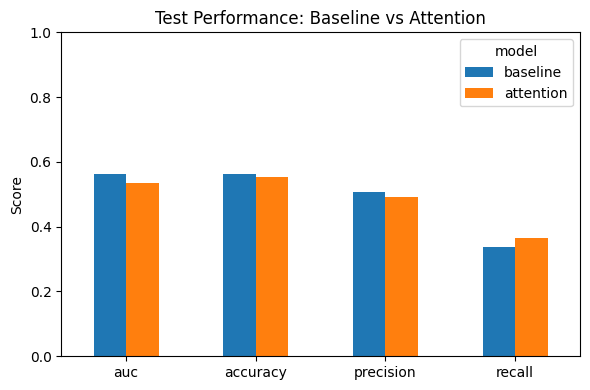

In [6]:
# ===== Baseline vs Attention: side-by-side comparison =====
import os, json, pandas as pd, matplotlib.pyplot as plt

BASE_JSON = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_baseline/metrics_summary.csv"  # from Cell 9
ATTN_JSON = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/logs/attention_test_metrics.json"  # from Cell 11

# Load baseline (csv with one row) and attention (json)
base_df = pd.read_csv(BASE_JSON) if os.path.exists(BASE_JSON) else None
with open(ATTN_JSON, "r") as f:
    attn_metrics = json.load(f)

# Normalize columns to comparable set
keep = ["accuracy", "auc", "precision", "recall"]
if base_df is not None:
    base_row = {k: float(base_df.iloc[0][k]) for k in keep if k in base_df.columns}
else:
   
    with open("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/logs/baseline_history.csv", "r") as _:
        raise ValueError("Please point BASE_JSON to your baseline metrics_summary.csv from Cell 9")

attn_row = {k: float(attn_metrics.get(k, 'nan')) for k in keep}

comp = pd.DataFrame([
    {"model": "baseline", **base_row},
    {"model": "attention", **attn_row},
])

# Print table and deltas
print("=== Baseline vs Attention (test set) ===")
display(comp)

delta = comp.set_index("model").diff().loc["attention"].to_dict()
print("\nΔ (attention - baseline):")
for k,v in delta.items():
    if k in keep:
        print(f"  {k}: {v:+.4f}")

# Plot bar chart for AUC/Accuracy/Precision/Recall
plot_cols = ["auc", "accuracy", "precision", "recall"]
ax = comp.set_index("model")[plot_cols].T.plot(kind="bar", figsize=(6,4), rot=0)
ax.set_title("Test Performance: Baseline vs Attention")
ax.set_ylabel("Score")
ax.set_ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


In [3]:
# ===== Cell 12: Monte Carlo Dropout Uncertainty (Attention CNN)=====
import os, numpy as np, pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

MODELS_DIR = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models"
EVAL_DIR   = "/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention"
os.makedirs(EVAL_DIR, exist_ok=True)

ATTN_CKPT  = os.path.join(MODELS_DIR, "attention_cnn.best.h5")
UNCERT_CSV = os.path.join(EVAL_DIR, "uncertainty_attention.csv")

# 1) MCDropout
class MCDropout(layers.Dropout):
    def call(self, inputs, training=None):
        # Force dropout behavior even when training=False
        return super().call(inputs, training=True)

# 2) SE block
def se_block(x, reduction=8):
    c = int(x.shape[-1])
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Dense(max(c // reduction, 8), activation="relu")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    s = layers.Reshape((1,1,c))(s)
    return layers.Multiply()([x, s])

# 3)Attention CNN with MCDropout
def build_attention_cnn_mc(input_shape=(64,64,1)):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D()(x)
    x = MCDropout(0.15)(x)   # <- MC

    # Block 2
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D()(x)
    x = MCDropout(0.20)(x)   # <- MC

    # Block 3
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D()(x)
    x = MCDropout(0.25)(x)   # <- MC

    # Head
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = se_block(x, reduction=8)

    x = layers.GlobalAveragePooling2D()(x)
    x = MCDropout(0.30)(x)   # <- MC
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="attention_mc_dropout")
    return model

# 4)Instantiate and load weights from the trained attention model
mc_model = build_attention_cnn_mc(input_shape=(64,64,1))
mc_model.load_weights(ATTN_CKPT)  # should now load cleanly
print("Loaded weights from:", ATTN_CKPT)

# 5) Monte Carlo sampling over test_ds
N_SAMPLES = 30
y_true_all, y_mean_all, y_std_all = [], [], []

for x_batch, y_batch in tqdm(test_ds, desc="MC Dropout Inference"):
    # Collect N stochastic predictions with BN in inference mode (training=False)
    # but Dropout active due to MCDropout
    preds = []
    for _ in range(N_SAMPLES):
        p = mc_model(x_batch, training=False).numpy().ravel()
        preds.append(p)
    preds = np.stack(preds, axis=0)  # (N_SAMPLES, batch)

    y_true_all.extend(y_batch.numpy().astype(int))
    y_mean_all.extend(preds.mean(axis=0))
    y_std_all. extend(preds.std(axis=0))

# 6) Save CSV
uncert_df = pd.DataFrame({
    "y_true": np.array(y_true_all, dtype=int),
    "y_prob_mean": np.array(y_mean_all, dtype=float),
    "y_prob_std":  np.array(y_std_all,  dtype=float),  # uncertainty
})
uncert_df.to_csv(UNCERT_CSV, index=False)
print("Saved MC Dropout uncertainty ->", UNCERT_CSV)
print(uncert_df.head(), "\nTotal rows:", len(uncert_df))


Loaded weights from: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models/attention_cnn.best.h5


MC Dropout Inference:   0%|                                                                             | 0/376 [00:00<?, ?it/s]2025-09-12 19:35:23.871999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [96100]
	 [[{{node Placeholder/_1}}]]
2025-09-12 19:35:23.872325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [96100]
	 [[{{node Placeholder/_1}}]]
MC Dropout Inference: 100%|█████████████████████████████████████████████████████████████████| 376/376 [2:41:19<00:00, 25.74s/it]


Saved MC Dropout uncertainty -> /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention/uncertainty_attention.csv
   y_true  y_prob_mean  y_prob_std
0       0     0.451911    0.021231
1       0     0.452440    0.024721
2       0     0.443226    0.028007
3       0     0.448826    0.022903
4       0     0.441824    0.021360 
Total rows: 96100


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

df = pd.read_csv("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention/uncertainty_attention.csv")
y_true = df["y_true"].values.astype(int)
y_prob = df["y_prob_mean"].values
y_pred = (y_prob >= 0.5).astype(int)
unc    = df["y_prob_std"].values

correct = (y_pred == y_true)
print("AUC of mean prob:", roc_auc_score(y_true, y_prob))

plt.figure(figsize=(6,4))
plt.hist(unc[correct], bins=40, alpha=0.6, label="Correct", density=True)
plt.hist(unc[~correct], bins=40, alpha=0.6, label="Incorrect", density=True)
plt.title("Uncertainty (std of MC probs): Correct vs Incorrect")
plt.xlabel("Predictive Std (uncertainty)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

print("Mean uncertainty (correct):   {:.4f}".format(unc[correct].mean()))
print("Mean uncertainty (incorrect): {:.4f}".format(unc[~correct].mean()))


[paths]
  root: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP
  ckpt: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models/attention_cnn.best.h5 | exists: True
  manifest: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/patch_manifest.csv | exists: True
  out_dir: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention/gradcam
[gradcam] model loaded.
[gradcam] last conv layer: b4_conv
[select] chosen 30 patches | class counts: {1: 15, 0: 15}
[gradcam] saved 30 overlays -> /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention/gradcam
[gradcam] manifest -> /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention/gradcam/gradcam_manifest.csv
[gradcam] sample display: overlay_1-1.png


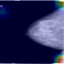

In [6]:
# ===== Cell 13: Grad-CAM overlays for Attention CNN====
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import Image, display


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ---------- Paths ----------
ROOT = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP")
PROC = ROOT / "processed"
MODELS_DIR = PROC / "models"
PATCHES_DIR = PROC / "patches"
MANIFEST_PATCH = PROC / "patch_manifest.csv"
OUT_DIR = PROC / "eval_attention" / "gradcam"
OUT_DIR.mkdir(parents=True, exist_ok=True)

ATTN_CKPT = MODELS_DIR / "attention_cnn.best.h5"
LAST_CONV_FALLBACK = "b4_conv"

print("[paths]")
print("  root:", ROOT)
print("  ckpt:", ATTN_CKPT, "| exists:", ATTN_CKPT.exists())
print("  manifest:", MANIFEST_PATCH, "| exists:", MANIFEST_PATCH.exists())
print("  out_dir:", OUT_DIR)

assert ATTN_CKPT.exists(), "Missing attention checkpoint .h5"
assert MANIFEST_PATCH.exists(), "Missing patch_manifest.csv (run Cells 5–9 first)"

# ------SAME Attention CNN as training (Cell 10) ----------
def se_block(x, reduction=8):
    c = int(x.shape[-1])
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Dense(max(c // reduction, 8), activation="relu")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    s = layers.Reshape((1, 1, c))(s)
    return layers.Multiply()([x, s])

def build_attention_cnn(input_shape=(64,64,1)):
    inp = layers.Input(shape=input_shape)
    # Block 1
    x = layers.Conv2D(32, 3, padding="same", use_bias=False, name="b1_conv")(inp)
    x = layers.BatchNormalization(name="b1_bn")(x); x = layers.ReLU(name="b1_relu")(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D(name="b1_pool")(x)
    x = layers.Dropout(0.15, name="b1_drop")(x)
    # Block 2
    x = layers.Conv2D(64, 3, padding="same", use_bias=False, name="b2_conv")(x)
    x = layers.BatchNormalization(name="b2_bn")(x); x = layers.ReLU(name="b2_relu")(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D(name="b2_pool")(x)
    x = layers.Dropout(0.20, name="b2_drop")(x)
    # Block 3
    x = layers.Conv2D(128, 3, padding="same", use_bias=False, name="b3_conv")(x)
    x = layers.BatchNormalization(name="b3_bn")(x); x = layers.ReLU(name="b3_relu")(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D(name="b3_pool")(x)
    x = layers.Dropout(0.25, name="b3_drop")(x)
    # Head (last conv)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False, name="b4_conv")(x)
    x = layers.BatchNormalization(name="b4_bn")(x); x = layers.ReLU(name="b4_relu")(x)
    x = se_block(x, reduction=8)
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(0.30, name="head_drop")(x)
    out = layers.Dense(1, activation="sigmoid", name="pred")(x)
    return keras.Model(inp, out, name="attention_se_cnn")

attn_model = build_attention_cnn()
attn_model.load_weights(str(ATTN_CKPT))
print("[gradcam] model loaded.")

# Determine last conv layer name
conv_layers = [l.name for l in attn_model.layers if isinstance(l, layers.Conv2D)]
LAST_CONV_NAME = LAST_CONV_FALLBACK if LAST_CONV_FALLBACK in conv_layers else conv_layers[-1]
last_conv_layer = attn_model.get_layer(LAST_CONV_NAME)
print("[gradcam] last conv layer:", last_conv_layer.name)

# Grad-CAM wrapper model
grad_model = keras.Model(
    [attn_model.inputs],
    [last_conv_layer.output, attn_model.output]
)

@tf.function
def gradcam_batch(batch_x):
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(batch_x, training=False)
        loss = preds[:, 0]
    grads = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(1,2), keepdims=True)  
    cam = tf.reduce_sum(weights * conv_out, axis=-1)           
    cam = tf.nn.relu(cam)
    # Resize CAM to 64x64 and normalize per item
    cam = tf.image.resize(cam[..., None], (64,64), method="bilinear")[..., 0]
    cmin = tf.reduce_min(cam, axis=(1,2), keepdims=True)
    cmax = tf.reduce_max(cam, axis=(1,2), keepdims=True)
    cam = (cam - cmin) / (cmax - cmin + 1e-8)
    return preds, cam

def cam_to_u8(cam2d):
    return (np.clip(cam2d, 0.0, 1.0) * 255.0).astype(np.uint8)

def overlay(gray_64_u8, cam_u8, alpha=0.35):
    if gray_64_u8.shape[:2] != (64,64):
        gray_64_u8 = cv2.resize(gray_64_u8, (64,64), interpolation=cv2.INTER_AREA)
    base_rgb = cv2.cvtColor(gray_64_u8, cv2.COLOR_GRAY2RGB)
    heat = cv2.applyColorMap(cam_u8, cv2.COLORMAP_JET)
    return cv2.addWeighted(base_rgb, 1.0, heat, alpha, 0)

# ---------- Load manifest and create a unified integer label ----------
df = pd.read_csv(MANIFEST_PATCH)

label_int = None
if "label" in df.columns:
    if df["label"].dtype == object:
        label_int = df["label"].map({"benign":0, "malignant":1})
    else:
        label_int = df["label"]
elif "pathology" in df.columns:
    label_int = df["pathology"].map({"benign":0, "malignant":1})
elif "label_int" in df.columns:
    label_int = df["label_int"]
else:
    raise ValueError("No label column found in patch_manifest.csv (expected label/pathology/label_int).")

df["label_int"] = label_int.astype(int)

# Restrict to test split
df = df[df["split"] == "test"].copy()

# Prefer PNG patches produced earlier; if absent, keep DICOM for fallback
def path_is_png(p):
    return isinstance(p, str) and p.lower().endswith(".png")
def path_is_dcm(p):
    return isinstance(p, str) and p.lower().endswith(".dcm")

df["source_path"] = df["source_path"].astype(str)
df["png_ok"] = df["source_path"].apply(lambda p: path_is_png(p) and Path(p).exists())
df["dcm_ok"] = df["source_path"].apply(lambda p: path_is_dcm(p) and Path(p).exists())

# Build selection preferring PNGs
df_png = df[df["png_ok"]].copy()
df_dcm = df[(~df["png_ok"]) & df["dcm_ok"]].copy()

def pick_balanced(frame, n_pos, n_neg):
    pos = frame[frame["label_int"] == 1]
    neg = frame[frame["label_int"] == 0]
    take = []
    if len(pos) > 0:
        take.append(pos.sample(min(n_pos, len(pos)), random_state=42))
    if len(neg) > 0:
        take.append(neg.sample(min(n_neg, len(neg)), random_state=42))
    if take:
        return pd.concat(take, ignore_index=True)
    return frame.head(0)


sample_png = pick_balanced(df_png, 15, 15)
need = 30 - len(sample_png)
if need > 0:
   
    need_pos = max(0, 15 - (sample_png["label_int"] == 1).sum())
    need_neg = max(0, 15 - (sample_png["label_int"] == 0).sum())
    sample_dcm = pick_balanced(df_dcm, need_pos, need_neg)
    
    if len(sample_dcm) < (need_pos + need_neg):
        extra_need = (need_pos + need_neg) - len(sample_dcm)
        remain = df_dcm.drop(sample_dcm.index)
        if len(remain) > 0:
            sample_dcm = pd.concat([sample_dcm, remain.sample(min(extra_need, len(remain)), random_state=42)], ignore_index=True)
    sample = pd.concat([sample_png, sample_dcm], ignore_index=True)
else:
    sample = sample_png.copy()


if len(sample) < 30:
    remaining = pd.concat([df_png.drop(sample_png.index), df_dcm], ignore_index=True)
    extra = 30 - len(sample)
    if len(remaining) > 0:
        sample = pd.concat([sample, remaining.sample(min(extra, len(remaining)), random_state=42)], ignore_index=True)

print(f"[select] chosen {len(sample)} patches | class counts:",
      sample["label_int"].value_counts().to_dict())

assert len(sample) > 0, "No usable test patches found. Ensure patches and manifest exist."

from pydicom.pixel_data_handlers.util import apply_voi_lut
import pydicom

def load_png_64(path, size=(64,64)):
    im = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if im is None:
        raise ValueError(f"Cannot read PNG: {path}")
    if im.shape[:2] != size:
        im = cv2.resize(im, size, interpolation=cv2.INTER_AREA)
    x = im.astype(np.float32)
    x = (x - x.min())/(x.max()-x.min()+1e-8)
    return im.astype(np.uint8), x[...,None][None,...]

def load_dcm_64(path, size=(64,64)):
    d = pydicom.dcmread(str(path))
    arr = apply_voi_lut(d.pixel_array, d)
    if getattr(d, "PhotometricInterpretation", "") == "MONOCHROME1":
        arr = np.max(arr) - arr
    arr = arr.astype(np.float32)
    arr -= arr.min()
    rng = arr.max()
    if rng > 0:
        arr /= rng
    img_u8 = (arr*255.0).clip(0,255).astype(np.uint8)
    if img_u8.shape[:2] != size:
        img_u8 = cv2.resize(img_u8, size, interpolation=cv2.INTER_AREA)
    x = img_u8.astype(np.float32)/255.0
    return img_u8, x[...,None][None,...]

def load_any_row(row):
    p = row["source_path"]
    if path_is_png(p) and Path(p).exists():
        return load_png_64(p)
    if path_is_dcm(p) and Path(p).exists():
        return load_dcm_64(p)
    raise ValueError(f"Neither PNG nor DICOM readable for row: {p}")

# ------- Grad-CAM  ----------
records = []
batch_imgs, grays, meta = [], [], []
BATCH = 32

def flush_batch():
    global batch_imgs, grays, meta, records
    if not batch_imgs:
        return
    bx = np.stack(batch_imgs, axis=0)
    preds, cams = gradcam_batch(tf.convert_to_tensor(bx, dtype=tf.float32))
    preds, cams = preds.numpy().squeeze(), cams.numpy()
    for i in range(len(batch_imgs)):
        cam_u8 = cam_to_u8(cams[i])
        ovl = overlay(grays[i], cam_u8, alpha=0.35)
        stem, y_true, src_path = meta[i]
        cam_path = OUT_DIR / f"cam_{stem}.png"
        ovl_path = OUT_DIR / f"overlay_{stem}.png"
        ok1 = cv2.imwrite(str(cam_path), cam_u8)
        ok2 = cv2.imwrite(str(ovl_path), ovl)
        records.append({
            "source_file": str(src_path),
            "label": int(y_true),
            "pred_prob": float(preds[i]),
            "cam_png": str(cam_path),
            "overlay_png": str(ovl_path),
            "write_ok": bool(ok1 and ok2),
        })
    batch_imgs, grays, meta = [], [], []

# Resume-safety: skip overlays already written
already = {p.name for p in OUT_DIR.glob("overlay_*.png")}

for _, row in sample.iterrows():
    src = row["source_path"]
    stem = Path(src).stem
    if f"overlay_{stem}.png" in already:
        continue
    gray, x = load_any_row(row)
    batch_imgs.append(x[0])
    grays.append(gray)
    meta.append((stem, int(row["label_int"]), src))
    if len(batch_imgs) == BATCH:
        flush_batch()
flush_batch()

out_csv = OUT_DIR / "gradcam_manifest.csv"
pd.DataFrame.from_records(records).to_csv(out_csv, index=False)
print(f"[gradcam] saved {len(records)} overlays -> {OUT_DIR}")
print(f"[gradcam] manifest -> {out_csv}")


ovls = sorted(OUT_DIR.glob("overlay_*.png"))
print("[gradcam] sample display:", ovls[0].name if ovls else "none")
if ovls:
    display(Image(filename=str(ovls[0])))


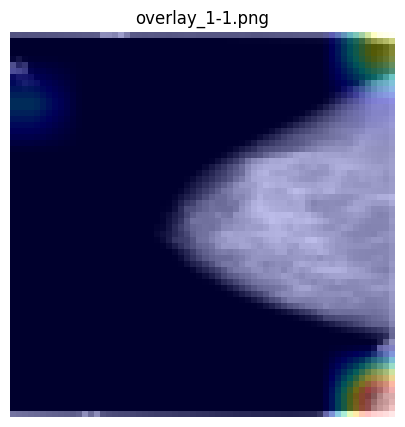

In [7]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

sample_imgs = sorted(Path(OUT_DIR).glob("overlay_*.png"))[:5]
plt.figure(figsize=(15,5))
for i, img_path in enumerate(sample_imgs):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(sample_imgs), i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_path.name)
plt.show()


In [8]:
# ===== Cell 14: Final wrap-up & packaging (resume-safe) =====
import os, sys, json, shutil, zipfile, datetime, textwrap
from pathlib import Path
import pandas as pd

ROOT = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP")
PROCESSED = ROOT / "processed"

# Source folders created in earlier cells
MODELS_DIR = PROCESSED / "models"
LOGS_DIR   = PROCESSED / "logs"
EVAL_DIR   = PROCESSED / "eval_baseline"        # baseline eval (from Cell 9/11)
EVAL_ATT   = PROCESSED / "eval_attention"        # attention eval (Cell 11/12)
EVAL_UQ    = EVAL_ATT / "uncertainty"            # uncertainty outputs (Cell 12)
EVAL_CAM   = EVAL_ATT / "gradcam"                # Grad-CAM outputs (Cell 13)
PATCH_MAN  = PROCESSED / "patch_manifest.csv"    # from Cell 5/5.1

#Destination (time-stamped) export folder
EXPORTS = PROCESSED / "exports"
EXPORTS.mkdir(parents=True, exist_ok=True)
stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT = EXPORTS / f"fyp_results_{stamp}"
OUT.mkdir(parents=True, exist_ok=True)

#Subfolders inside the export
DST_MODELS = OUT / "models"
DST_LOGS   = OUT / "logs"
DST_METRICS= OUT / "metrics"
DST_PLOTS  = OUT / "plots"
DST_UQ     = OUT / "uncertainty"
DST_CAM    = OUT / "gradcam"
DST_MISC   = OUT / "misc"

for d in [DST_MODELS, DST_LOGS, DST_METRICS, DST_PLOTS, DST_UQ, DST_CAM, DST_MISC]:
    d.mkdir(parents=True, exist_ok=True)

def safe_copy_glob(src_dir: Path, patterns, dst_dir: Path):
    """Copy files matching any pattern from src_dir to dst_dir if they exist."""
    count = 0
    for pat in patterns:
        for p in src_dir.glob(pat):
            if p.is_file():
                shutil.copy2(p, dst_dir / p.name)
                count += 1
    return count

def safe_copy_files(files, dst_dir: Path):
    count = 0
    for p in files:
        p = Path(p)
        if p.exists() and p.is_file():
            shutil.copy2(p, dst_dir / p.name)
            count += 1
    return count

# 1) Copy models (baseline + attention best checkpoints)
models_copied = safe_copy_glob(MODELS_DIR, ["*best*.h5", "*.keras"], DST_MODELS)

# 2) Copy training logs (CSV histories)
logs_copied = safe_copy_glob(LOGS_DIR, ["*history*.csv", "*.log", "*.txt"], DST_LOGS)

# 3) Copy evaluation CSVs (baseline + attention)
metrics_copied = 0
plots_copied   = 0
for src in [EVAL_DIR, EVAL_ATT]:
    if src.exists():
        metrics_copied += safe_copy_glob(src, ["*.csv", "*.json"], DST_METRICS)
        plots_copied   += safe_copy_glob(src, ["*roc*.png", "*auc*.png", "*cm*.png", "*curve*.png"], DST_PLOTS)

# 4) Copy uncertainty outputs (MC dropout)
if EVAL_UQ.exists():
    metrics_copied += safe_copy_glob(EVAL_UQ, ["*.csv", "*.json"], DST_UQ)
    plots_copied   += safe_copy_glob(EVAL_UQ, ["*.png"], DST_UQ)

# 5) Copy Grad-CAM overlays + manifest
if EVAL_CAM.exists():
    metrics_copied += safe_copy_glob(EVAL_CAM, ["*manifest*.csv"], DST_CAM)
    plots_copied   += safe_copy_glob(EVAL_CAM, ["overlay_*.png", "cam_*.png"], DST_CAM)

# 6) Copy patch manifest and any other helpful context
misc_copied = safe_copy_files([PATCH_MAN], DST_MISC)

# --------- Summarize key metrics  to README ---------
def try_read_csv(path: Path):
    try:
        if path.exists():
            return pd.read_csv(path)
    except Exception:
        return None
    return None

# Likely file names (adjust automatically if variants exist)
baseline_hist   = next(LOGS_DIR.glob("baseline_history*.csv"), None)
attention_hist  = next(LOGS_DIR.glob("attention_history*.csv"), None)

baseline_eval   = next((p for p in (EVAL_DIR.glob("*.csv") if EVAL_DIR.exists() else [])
                        if "test" in p.stem or "metrics" in p.stem), None)
attention_eval  = next((p for p in (EVAL_ATT.glob("*.csv") if EVAL_ATT.exists() else [])
                        if "test" in p.stem or "metrics" in p.stem), None)

uq_csv          = EVAL_UQ / "uncertainty_attention.csv" if EVAL_UQ.exists() else None
gradcam_manifest= EVAL_CAM / "gradcam_manifest.csv" if EVAL_CAM.exists() else None

df_base_hist  = try_read_csv(baseline_hist) if baseline_hist else None
df_attn_hist  = try_read_csv(attention_hist) if attention_hist else None
df_base_eval  = try_read_csv(baseline_eval) if baseline_eval else None
df_attn_eval  = try_read_csv(attention_eval) if attention_eval else None
df_uq         = try_read_csv(uq_csv) if uq_csv else None
df_cam        = try_read_csv(gradcam_manifest) if gradcam_manifest else None

def best_val_auc(df_hist: pd.DataFrame):
    if df_hist is None or "val_auc" not in df_hist.columns:
        return None, None
    i = df_hist["val_auc"].idxmax()
    row = df_hist.loc[i]
    return float(row["val_auc"]), int(row.get("epoch", i))

base_best_auc, base_best_epoch = best_val_auc(df_base_hist)
attn_best_auc, attn_best_epoch = best_val_auc(df_attn_hist)

def extract_test_metrics(df_eval: pd.DataFrame):
    """
    Expect columns like: auc, accuracy, precision, recall, tn, fp, fn, tp, etc.
    Returns a dict of the most informative fields if present.
    """
    if df_eval is None or len(df_eval) == 0:
        return {}
    s = df_eval.iloc[0].to_dict()
    out = {}
    for k in ["auc","accuracy","precision","recall","specificity","f1","tn","fp","fn","tp"]:
        if k in s:
            try:
                out[k] = float(s[k])
            except Exception:
                out[k] = s[k]
    return out

base_test = extract_test_metrics(df_base_eval)
attn_test = extract_test_metrics(df_attn_eval)

# Uncertainty quick stats (mean of predicted std)
uq_stats = {}
if df_uq is not None and all(c in df_uq.columns for c in ["y_true","y_prob","y_std"]):
    uq_stats = {
        "n_rows": int(len(df_uq)),
        "mean_std_overall": float(df_uq["y_std"].mean()),
        "mean_std_correct": float(df_uq.loc[(df_uq["y_prob"]>=0.5) == (df_uq["y_true"]==1), "y_std"].mean()),
        "mean_std_incorrect": float(df_uq.loc[(df_uq["y_prob"]>=0.5) != (df_uq["y_true"]==1), "y_std"].mean()),
    }

# Grad-CAM sample count
cam_count = 0
if df_cam is not None:
    cam_count = int(len(df_cam))

# Build README
readme_lines = []
readme_lines.append("Final Export Summary")
readme_lines.append("=" * 72)
readme_lines.append(f"Created: {datetime.datetime.now().isoformat(timespec='seconds')}")
readme_lines.append(f"Bundle : {OUT.name}")
readme_lines.append("")
readme_lines.append("Folders:")
readme_lines.append(f"  models/       -> best checkpoints (.h5)")
readme_lines.append(f"  logs/         -> training histories (.csv)")
readme_lines.append(f"  metrics/      -> evaluation CSV/JSON (baseline + attention + UQ)")
readme_lines.append(f"  plots/        -> ROC curves, confusion matrices, etc.")
readme_lines.append(f"  uncertainty/  -> Monte Carlo dropout predictions & stats")
readme_lines.append(f"  gradcam/      -> overlay_*.png heatmaps + gradcam_manifest.csv")
readme_lines.append(f"  misc/         -> patch_manifest.csv")
readme_lines.append("")

def fmt(v):
    return "NA" if v is None else (f"{v:.4f}" if isinstance(v, (int, float)) else str(v))

readme_lines.append("Training (validation) summary")
readme_lines.append("-" * 72)
readme_lines.append(f"Baseline best val AUC : {fmt(base_best_auc)} @ epoch {fmt(base_best_epoch)}")
readme_lines.append(f"Attention best val AUC: {fmt(attn_best_auc)} @ epoch {fmt(attn_best_epoch)}")
readme_lines.append("")

readme_lines.append("Test-set summary (if available)")
readme_lines.append("-" * 72)
if base_test:
    readme_lines.append("Baseline:")
    for k,v in base_test.items():
        readme_lines.append(f"  {k:>10}: {fmt(v)}")
else:
    readme_lines.append("Baseline: NA")

if attn_test:
    readme_lines.append("Attention:")
    for k,v in attn_test.items():
        readme_lines.append(f"  {k:>10}: {fmt(v)}")
else:
    readme_lines.append("Attention: NA")
readme_lines.append("")

readme_lines.append("Uncertainty (MC Dropout) summary")
readme_lines.append("-" * 72)
if uq_stats:
    for k,v in uq_stats.items():
        readme_lines.append(f"  {k:>22}: {fmt(v)}")
else:
    readme_lines.append("  NA")
readme_lines.append("")

readme_lines.append("Grad-CAM")
readme_lines.append("-" * 72)
readme_lines.append(f"  overlays saved: {cam_count}")
readme_lines.append("")

readme_lines.append("Counts")
readme_lines.append("-" * 72)
readme_lines.append(f"  models copied     : {models_copied}")
readme_lines.append(f"  logs copied       : {logs_copied}")
readme_lines.append(f"  metrics copied    : {metrics_copied}")
readme_lines.append(f"  plots copied      : {plots_copied}")
readme_lines.append(f"  misc copied       : {misc_copied}")
readme_lines.append("")

# Write README
readme_path = OUT / "README.txt"
readme_path.write_text("\n".join(readme_lines))
print("[export] Wrote:", readme_path)

# --------- Zip the bundle ---------
zip_path = EXPORTS / f"{OUT.name}.zip"
def zipdir(src_dir: Path, zip_file: Path):
    with zipfile.ZipFile(zip_file, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
        for p in src_dir.rglob("*"):
            if p.is_file():
                zf.write(p, arcname=p.relative_to(src_dir))
zipdir(OUT, zip_path)

# Final report
print("\n[export] Bundle created.")
print("  Folder:", OUT)
print("  Zip   :", zip_path)

for p in sorted(OUT.glob("*")):
    if p.is_dir():
        print(" ", p.name, "->", len(list(p.iterdir())), "items")


[export] Wrote: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/exports/fyp_results_20250913_162523/README.txt

[export] Bundle created.
  Folder: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/exports/fyp_results_20250913_162523
  Zip   : /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/exports/fyp_results_20250913_162523.zip
  gradcam -> 4 items
  logs -> 3 items
  metrics -> 9 items
  misc -> 1 items
  models -> 2 items
  plots -> 7 items
  uncertainty -> 0 items


In [3]:
# ===== Cell 15: Final metrics + plots (JSON, Confusion Matrix, ROC/PR) [FIXED] =====
import os, json, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_curve,
    average_precision_score, log_loss, precision_score, recall_score,
    f1_score, accuracy_score
)

# -----------------------
# Paths
# -----------------------
ROOT = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP")
PROC = ROOT / "processed"
EXPORTS = PROC / "exports"
METRICS_DIR = PROC / "metrics"
PLOTS_DIR = PROC / "plots"
LOGS_DIR = PROC / "logs"

METRICS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Prefer predictions from Attention model
candidates = [
    EXPORTS.glob("fyp_results_*/metrics/test_predictions_attention.csv"),
    EXPORTS.glob("fyp_results_*/metrics/test_predictions.csv"),
    [METRICS_DIR / "test_predictions_attention.csv"],
    [METRICS_DIR / "test_predictions.csv"],
]
pred_path = None
for g in candidates:
    for p in (sorted(g, key=str) if not isinstance(g, list) else g):
        if Path(p).exists():
            pred_path = Path(p)
if pred_path is None:
    raise FileNotFoundError(
        "Could not find test_predictions CSV in exports/ or processed/metrics/."
    )
print(f"[metrics] Using predictions CSV: {pred_path}")

# -----------------------
# Load predictions (expect y_true, y_prob)
# -----------------------
df = pd.read_csv(pred_path)
y_true_col = "y_true" if "y_true" in df.columns else ("label" if "label" in df.columns else None)
y_prob_col = "y_prob" if "y_prob" in df.columns else ("prob" if "prob" in df.columns else None)
if y_true_col is None or y_prob_col is None:
    raise ValueError(f"CSV must contain y_true and y_prob; got {list(df.columns)}")

y_true = df[y_true_col].astype(int).to_numpy()
y_prob = df[y_prob_col].astype(float).to_numpy()

# -----------------------
# Scalar metrics -default threshold
# -----------------------
threshold = 0.50
y_pred = (y_prob >= threshold).astype(int)

fpr, tpr, _ = roc_curve(y_true, y_prob)
prec, rec, _ = precision_recall_curve(y_true, y_prob)

summary = {
    "n_samples": int(len(y_true)),
    "threshold": float(threshold),
    "accuracy": float(accuracy_score(y_true, y_pred)),
    "roc_auc": float(auc(fpr, tpr)),
    "pr_auc": float(average_precision_score(y_true, y_prob)),
    "precision": float(precision_score(y_true, y_pred, zero_division=0)),
    "recall": float(recall_score(y_true, y_pred, zero_division=0)),
    "f1": float(f1_score(y_true, y_pred, zero_division=0)),
    "log_loss": float(log_loss(y_true, np.clip(y_prob, 1e-6, 1-1e-6))),
}
print("\n[metrics] Summary:", summary)

stem = "attention" if "attention" in pred_path.name else "baseline"
json_path = METRICS_DIR / f"test_metrics_{stem}.json"
with open(json_path, "w") as f:
    json.dump(summary, f, indent=2)

# -----------------------
# Confusion matrix (CSV + PNG)
# -----------------------
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
cm_df = pd.DataFrame(
    cm, index=["Benign (True 0)", "Malignant (True 1)"],
    columns=["Pred Benign (0)", "Pred Malignant (1)"]
)
cm_csv = METRICS_DIR / "confusion_matrix.csv"
cm_df.to_csv(cm_csv, index=True)

fig, ax = plt.subplots(figsize=(7.5, 3.8), dpi=200)
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0,1], labels=["Pred Benign (0)", "Pred Malignant (1)"])
ax.set_yticks([0,1], labels=["Benign (True 0)", "Malignant (True 1)"])
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{cm[i,j]:,}", ha="center", va="center",
                color="white" if cm[i,j] > cm.max()/2 else "black", fontsize=11)
ax.set_title("Confusion Matrix")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
cm_png = METRICS_DIR / "confusion_matrix.png"
fig.savefig(cm_png, bbox_inches="tight")
plt.close(fig)

# -----------------------
# ROC & PR curves (PNGs)
# -----------------------
# ROC
roc_auc_val = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
ax.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_val:.3f}")
ax.plot([0,1], [0,1], "--", color="gray", lw=1)
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve"); ax.legend(loc="lower right")
fig.tight_layout()
roc_png = PLOTS_DIR / "roc_curve.png"
fig.savefig(roc_png, bbox_inches="tight")
plt.close(fig)

# PR
pr_auc_val = average_precision_score(y_true, y_prob)
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
ax.plot(rec, prec, label=f"PR AUC = {pr_auc_val:.3f}")
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve"); ax.legend(loc="lower left")
fig.tight_layout()
pr_png = PLOTS_DIR / "pr_curve.png"
fig.savefig(pr_png, bbox_inches="tight")
plt.close(fig)

# -----------------------
# Build tidy history_long.csv -if logs exists
# -----------------------
history_long = []
def add_history(csv_path: Path, model_name: str):
    if csv_path.exists():
        try:
            h = pd.read_csv(csv_path)
            if "epoch" not in h.columns:
                h = h.reset_index().rename(columns={"index":"epoch"})
            for col in ["loss","accuracy","auc","val_loss","val_accuracy","val_auc"]:
                if col in h.columns:
                    history_long.append(
                        h[["epoch", col]].assign(metric=col, model=model_name).rename(columns={col:"value"})
                    )
        except Exception as e:
            print(f"[warn] Could not read {csv_path.name}: {e}")

add_history(LOGS_DIR / "baseline_history.csv", "baseline")
add_history(LOGS_DIR / "attention_history.csv", "attention")

if history_long:
    hist_long_df = pd.concat(history_long, ignore_index=True)
    hist_long_csv = PLOTS_DIR / "history_long.csv"
    hist_long_df.to_csv(hist_long_csv, index=False)
    print(f"[plots] history_long.csv -> {hist_long_csv}")
else:
    print("[plots] No history CSVs found to build history_long.csv (OK).")

# -----------------------
# Mirror into newest export bundle (DIRECTORIES ONLY; ignore .zip)
# -----------------------
export_dirs = [p for p in EXPORTS.glob("fyp_results_*") if p.is_dir()]
if export_dirs:
    latest = sorted(export_dirs)[-1]
    (latest / "metrics").mkdir(parents=True, exist_ok=True)
    (latest / "plots").mkdir(parents=True, exist_ok=True)

    for p in [json_path, cm_csv, cm_png]:
        shutil.copy2(p, latest / "metrics")
    for p in [roc_png, pr_png]:
        shutil.copy2(p, latest / "plots")
    if history_long:
        shutil.copy2(hist_long_csv, latest / "plots")

    print("\n[metrics] Wrote:")
    print(f"  {json_path}")
    print(f"  {cm_csv}")
    print(f"  {cm_png}")
    print(f"[metrics] Also mirrored into: {latest / 'metrics'}")
    print(f"[plots] ROC/PR -> {latest / 'plots'}")
else:
    print("\n[info] No export folder found (only zip). Files are in processed/metrics and processed/plots.")

print("\nCell 15 complete.")


[metrics] Using predictions CSV: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/exports/fyp_results_20250913_162523/metrics/test_predictions.csv

[metrics] Summary: {'n_samples': 96100, 'threshold': 0.5, 'accuracy': 0.5636732570239334, 'roc_auc': 0.5604288907720997, 'pr_auc': 0.4826579471764925, 'precision': 0.506258643310521, 'recall': 0.33764544508561156, 'f1': 0.4051074696743988, 'log_loss': 0.6827309727235876}
[plots] history_long.csv -> /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/plots/history_long.csv

[metrics] Wrote:
  /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/metrics/test_metrics_baseline.json
  /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/metrics/confusion_matrix.csv
  /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/metrics/confusion_matrix.png
[metrics] Also mirrored into: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/exports/fyp_results_20250913_162523/metrics
[plots] ROC/PR -> /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/exports/fyp_

## Main Report -  Figures 

In [15]:
#raw CBIS-DDSM mammogram images

def load_dicom_uint8(dicom_path: str | Path) -> tuple[np.ndarray, pydicom.dataset.FileDataset]:
    """
    Read a DICOM and return a 2D uint8 image (0..255) with VOI LUT and MONOCHROME handling.
    No resizing, no model pre-processing.
    """
    ds = pydicom.dcmread(str(dicom_path))

    # get pixels
    if hasattr(ds, "pixel_array"):
        arr = ds.pixel_array
    else:
        raise ValueError("DICOM has no pixel data.")

    try:
        arr = apply_voi_lut(arr, ds)
    except Exception:
        pass

    arr = arr.astype(np.float32)

    photometric = getattr(ds, "PhotometricInterpretation", "").upper()
    if photometric == "MONOCHROME1":
        arr = arr.max() - arr

    arr -= arr.min()
    if arr.max() > 0:
        arr = arr / arr.max()
    img_u8 = (arr * 255.0).clip(0, 255).astype(np.uint8)

    return img_u8, ds


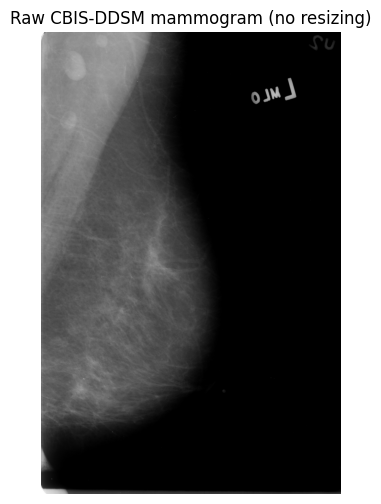

Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/notebooks/figure1_mammogram.png


In [6]:
dicom_path = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/dataset/raw_dicom/CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO/08-29-2017-DDSM-NA-17613/1.000000-full mammogram images-97934/1-1.dcm")


img, ds = load_dicom_uint8(dicom_path)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Raw CBIS-DDSM mammogram (no resizing)")
plt.show()

# Save PNG 
out_png = Path("figure1_mammogram.png")
plt.imsave(out_png, img, cmap="gray")
print("Saved:", out_png.resolve())


In [7]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras

clf_model = None
for name in ["model", "attention_model", "best_model"]:
    if name in globals() and isinstance(globals()[name], keras.Model):
        clf_model = globals()[name]
        print(f"[INFO] Using existing model variable: {name}")
        break

if clf_model is None:
    from tensorflow.keras import layers

    def se_block(x, reduction=8):
        c = x.shape[-1]
        s = layers.GlobalAveragePooling2D()(x)
        s = layers.Dense(max(c // reduction, 8), activation="relu")(s)
        s = layers.Dense(c, activation="sigmoid")(s)
        s = layers.Reshape((1,1,c))(s)
        return layers.Multiply()([x, s])

    def build_attention_model(input_shape=(64,64,1), last_conv_name="b4_conv"):
        inp = layers.Input(shape=input_shape)
        # Block 1
        x = layers.Conv2D(32,3,padding="same",use_bias=False)(inp)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
        x = se_block(x, reduction=8)
        x = layers.MaxPooling2D()(x); x = layers.Dropout(0.15)(x)
        # Block 2
        x = layers.Conv2D(64,3,padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
        x = se_block(x, reduction=8)
        x = layers.MaxPooling2D()(x); x = layers.Dropout(0.20)(x)
        # Block 3
        x = layers.Conv2D(128,3,padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
        x = se_block(x, reduction=8)
        x = layers.MaxPooling2D()(x); x = layers.Dropout(0.25)(x)
        # Head
        x = layers.Conv2D(256,3,padding="same",use_bias=False,name=last_conv_name)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
        x = se_block(x, reduction=8)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.30)(x)
        out = layers.Dense(1, activation="sigmoid")(x)
        return keras.Model(inp, out, name="attention_se_cnn")

    ATTENTION_WEIGHTS = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/models/attention_cnn.best.h5")
    assert ATTENTION_WEIGHTS.exists(), f"Weights not found: {ATTENTION_WEIGHTS}"

    clf_model = build_attention_model()
    clf_model.load_weights(str(ATTENTION_WEIGHTS))
    print("[INFO] Built and loaded attention model from weights.")


2025-09-19 23:52:33.303554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[INFO] Built and loaded attention model from weights.


In [13]:
import cv2

def ensure_gray64(img: np.ndarray) -> np.ndarray:
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img.shape[:2] != (64,64):
        img = cv2.resize(img, (64,64), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)
    img -= img.min()
    if img.max() > 0: img /= img.max()
    return img

X_candidate = None
for name in ["X_test", "x_test", "X_val", "x_val", "X_test_patches", "X_test_final"]:
    if name in globals():
        arr = np.asarray(globals()[name])
        if arr.ndim in (3,4):
            X_candidate = arr
            print(f"[INFO] Using array from variable: {name} with shape {arr.shape}")
            break

if X_candidate is not None:
    if X_candidate.ndim == 3:
        patch = X_candidate[0][..., None]
    else:
        patch = X_candidate[0]
else:
    png_path = next(Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP").rglob("*.png"))
    print("[INFO] Loaded patch from:", png_path)
    raw = cv2.imread(str(png_path), cv2.IMREAD_GRAYSCALE)
    patch = ensure_gray64(raw)[..., None]

x = patch[None, ...].astype(np.float32)
print("Input patch shape:", x.shape) 


[INFO] Loaded patch from: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/notebooks/figure1_mammogram.png
Input patch shape: (1, 64, 64, 1)


/var/folders/05/6txqdn6n4hl0_wlmfbcw2n1h0000gn/T/ipykernel_28696/657239798.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


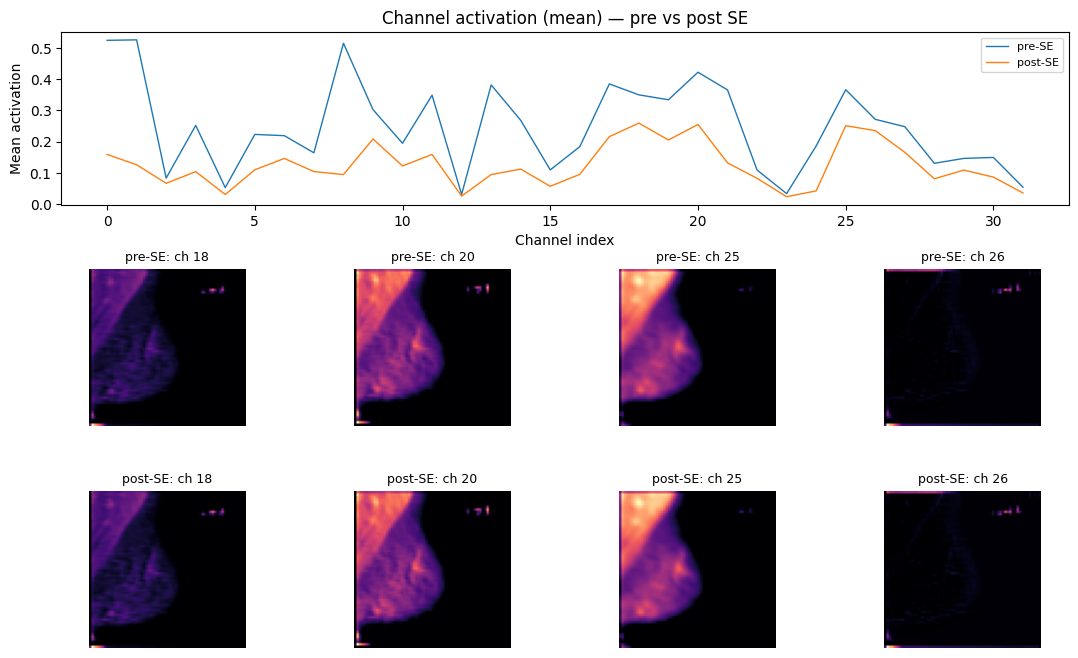

Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/notebooks/figure3_attention_effect.png


In [14]:
#figure 3 report 

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(13, 8))
gs = gridspec.GridSpec(nrows=3, ncols=4, height_ratios=[1.1, 1, 1], hspace=0.4, wspace=0.25)

# Bar chart spans the top row (all 4 columns)
ax1 = fig.add_subplot(gs[0, :])
xpos = np.arange(C)
ax1.plot(xpos, pre_means, label="pre-SE", linewidth=1)
ax1.plot(xpos, post_means, label="post-SE", linewidth=1)
ax1.set_title("Channel activation (mean) — pre vs post SE")
ax1.set_xlabel("Channel index")
ax1.set_ylabel("Mean activation")
ax1.legend(loc="upper right", fontsize=8)

# top-4 channels (two rows: pre on row 2, post on row 3)
for j, ch in enumerate(top_idx):
    # row 1 of heatmaps (pre-SE), columns 0..3
    ax_pre = fig.add_subplot(gs[1, j])
    ax_pre.imshow(pre_fm[:, :, ch], cmap="magma")
    ax_pre.set_title(f"pre-SE: ch {ch}", fontsize=9)
    ax_pre.axis("off")

    # row 2 of heatmaps (post-SE)
    ax_post = fig.add_subplot(gs[2, j])
    ax_post.imshow(post_fm[:, :, ch], cmap="magma")
    ax_post.set_title(f"post-SE: ch {ch}", fontsize=9)
    ax_post.axis("off")

plt.tight_layout()
out = Path("figure3_attention_effect.png")
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out.resolve())


In [19]:
# ==== Figure 4 inputs: load uncertainty CSV (robust pathing) ====

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP")
PROCESSED = ROOT / "processed"
PLOTS_DIR = PROCESSED / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# --- Load CSV  ---
candidates = [
    PROCESSED / "eval_attention" / "uncertainty_attention.csv",
    PROCESSED / "metrics" / "uncertainty_attention.csv",
    PROCESSED / "eval_attention" / "test_predictions_attention.csv",  # extra fallback
]
csv_path = next((p for p in candidates if p.exists()), None)
assert csv_path is not None, "Couldn't find the CSV. Adjust the candidates list to your path."
df = pd.read_csv(csv_path)
print("Loaded:", csv_path)
print("Columns:", list(df.columns))

def pick_col(cols, preferred_keywords, also_ok=()):
    """Return first column whose LOWER name contains any preferred keyword; then try also_ok."""
    low = [c.lower() for c in cols]
    for keys in (preferred_keywords, also_ok):
        for k in keys:
            for i, name in enumerate(low):
                if k in name:
                    return cols[i]
    return None

def find_or_build_prob_and_uncertainty(df: pd.DataFrame):
    cols = list(df.columns)

    p_col = pick_col(cols,
        preferred_keywords=("mc_mean","pred_prob","prob","probability","p_hat"),
        also_ok=("score","pred","prediction","y_prob"))
    y_col = pick_col(cols,
        preferred_keywords=("label","y_true","target","gt","ground","truth"),
        also_ok=("class","actual"))
    u_col = pick_col(cols,
        preferred_keywords=("mc_std","std","uncertainty","sigma","stddev"),
        also_ok=("variance","var"))

    per_pass_cols = [c for c in cols if re.search(r'(mc|drop|pass|sample).*?\d', c.lower())]
    if (u_col is None or p_col is None) and per_pass_cols:
        # keep only numeric pass columns
        pp = df[per_pass_cols].apply(pd.to_numeric, errors="coerce")
        # construct if needed
        if p_col is None:
            df["__mc_mean__"] = pp.mean(axis=1).astype(float)
            p_col = "__mc_mean__"
        if u_col is None:
            df["__mc_std__"] = pp.std(axis=1).astype(float)
            u_col = "__mc_std__"

    # Final sanity checks
    assert p_col is not None, "Couldn't detect a probability column. Check your CSV header."
    if y_col is None:
        df["__dummy_y__"] = np.nan
        y_col = "__dummy_y__"
    assert u_col is not None, "Couldn't detect or reconstruct an uncertainty (std) column."

    return p_col, y_col, u_col

p_col, y_col, u_col = find_or_build_prob_and_uncertainty(df)
print(f"Using columns -> prob: {p_col} | label: {y_col} | uncertainty: {u_col}")


Loaded: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/eval_attention/uncertainty_attention.csv
Columns: ['y_true', 'y_prob_mean', 'y_prob_std']
Using columns -> prob: y_prob_mean | label: y_true | uncertainty: y_prob_std


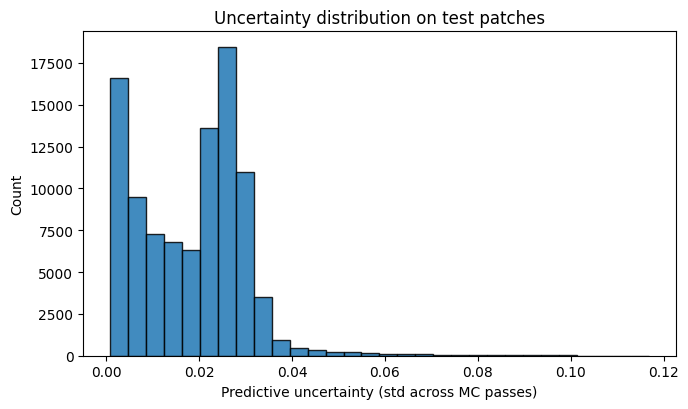

Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/plots/uncertainty_histogram.png


In [20]:
plt.figure(figsize=(7,4.2))
vals = pd.to_numeric(df[u_col], errors="coerce").dropna().values
plt.hist(vals, bins=30, edgecolor="black", alpha=0.85)
plt.xlabel("Predictive uncertainty (std across MC passes)")
plt.ylabel("Count")
plt.title("Uncertainty distribution on test patches")
plt.tight_layout()
out_unc_hist = PLOTS_DIR / "uncertainty_histogram.png"
plt.savefig(out_unc_hist, dpi=200)
plt.show()
print("Saved:", out_unc_hist)


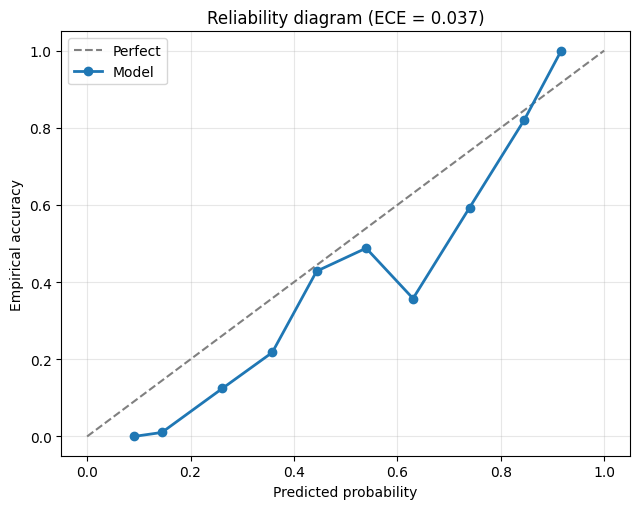

Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/plots/reliability_diagram.png


In [21]:
probs = np.clip(pd.to_numeric(df[p_col], errors="coerce").dropna().values, 1e-6, 1-1e-6)


y_series = pd.to_numeric(df[y_col], errors="coerce")
if y_series.notna().sum() >= 10:
    y_true = y_series.dropna().astype(int).values
    # align lengths if the dropna affected size
    n = min(len(probs), len(y_true))
    probs, y_true = probs[:n], y_true[:n]

    n_bins = 10
    bins = np.linspace(0,1,n_bins+1)
    bin_ids = np.digitize(probs, bins) - 1

    bin_acc, bin_conf, bin_counts = [], [], []
    for b in range(n_bins):
        m = bin_ids == b
        if m.sum() == 0:
            bin_acc.append(np.nan); bin_conf.append((bins[b]+bins[b+1])/2); bin_counts.append(0)
            continue
        bin_acc.append(y_true[m].mean())
        bin_conf.append(probs[m].mean())
        bin_counts.append(int(m.sum()))

    ece = 0.0
    total = len(probs)
    for b in range(n_bins):
        if bin_counts[b] == 0 or np.isnan(bin_acc[b]): 
            continue
        ece += (bin_counts[b]/total) * abs(bin_acc[b] - bin_conf[b])

    plt.figure(figsize=(6.5,5.2))
    plt.plot([0,1],[0,1],"--",color="gray",label="Perfect")
    valid = ~np.isnan(bin_acc)
    plt.plot(np.array(bin_conf)[valid], np.array(bin_acc)[valid], marker="o", linewidth=2, label="Model")
    plt.xlabel("Predicted probability"); plt.ylabel("Empirical accuracy")
    plt.title(f"Reliability diagram (ECE = {ece:.3f})")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    out_cal = PLOTS_DIR / "reliability_diagram.png"
    plt.savefig(out_cal, dpi=200); plt.show()
    print("Saved:", out_cal)
else:
    print("Calibration skipped: couldn't find a valid binary label column. "
          "Histogram above is still valid for uncertainty.")


In [22]:
# === Figure 5 generator: Grad-CAM panels (4 examples) =========================
import os, io, json, glob, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ----- Project paths (match  app.py) -----
ROOT          = Path("/Volumes/DUAL DRIVE/Azmina_MammoMind_FYP")
PROCESSED     = ROOT / "processed"
MODELS_DIR    = PROCESSED / "models"
EVAL_DIR      = PROCESSED / "eval_attention"
FIG_DIR       = PROCESSED / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

ATTN_CKPT     = MODELS_DIR / "attention_cnn.best.h5"
INPUT_SIZE    = (64, 64)
LAST_CONV_NAME = "b4_conv"

# ----- Small helpers (same preprocessing as app) -----
def ensure_gray_64(img: np.ndarray) -> np.ndarray:
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img.shape[:2] != INPUT_SIZE:
        img = cv2.resize(img, INPUT_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)
    img -= img.min()
    if img.max() > 0:
        img /= img.max()
    return img

def read_image_any(path: Path) -> np.ndarray:
    name = str(path).lower()
    if name.endswith(".dcm"):
        ds = pydicom.dcmread(str(path))
        assert hasattr(ds, "pixel_array"), "DICOM has no pixel data."
        arr = ds.pixel_array.astype(np.float32)
        try:
            from pydicom.pixel_data_handlers.util import apply_voi_lut
            arr = apply_voi_lut(arr, ds).astype(np.float32)
        except Exception:
            pass
        arr -= arr.min()
        if arr.max() > 0:
            arr /= arr.max()
        return (arr*255).astype(np.uint8)
    else:
        im = cv2.imdecode(np.fromfile(str(path), np.uint8), cv2.IMREAD_GRAYSCALE)
        if im is None:
            raise ValueError(f"Could not read: {path}")
        return im

def se_block(x, reduction=8):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Dense(max(c // reduction, 8), activation="relu")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    s = layers.Reshape((1,1,c))(s)
    return layers.Multiply()([x, s])

def build_attention_model(input_shape=(64,64,1), last_conv_name="b4_conv"):
    inp = layers.Input(shape=input_shape)
    # Block 1
    x = layers.Conv2D(32,3,padding="same",use_bias=False)(inp)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.15)(x)
    # Block 2
    x = layers.Conv2D(64,3,padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.20)(x)
    # Block 3
    x = layers.Conv2D(128,3,padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.25)(x)
    # Head
    x = layers.Conv2D(256,3,padding="same",use_bias=False,name=last_conv_name)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = se_block(x, reduction=8)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.30)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inp, out, name="attention_se_cnn")

def gradcam_u8(model, gray64: np.ndarray, last_conv_name: str):
    x = gray64[None, ..., None]
    conv = model.get_layer(last_conv_name)
    grad_model = keras.Model([model.inputs],[conv.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x, training=False)
        loss = preds[:,0]
    grads  = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.einsum("hwc,c->hw", conv_out[0], weights)
    cam = tf.maximum(cam, 0) / (tf.reduce_max(cam)+1e-6)
    cam = cv2.resize(cam.numpy().astype(np.float32), INPUT_SIZE, interpolation=cv2.INTER_CUBIC)
    return np.clip(cam*255.0, 0, 255).astype(np.uint8)

def overlay_cam(gray64: np.ndarray, cam8: np.ndarray, alpha=0.35) -> np.ndarray:
    base = (gray64*255.0).astype(np.uint8)
    base_rgb = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)
    heat = cv2.applyColorMap(cam8, cv2.COLORMAP_TURBO)
    return cv2.addWeighted(base_rgb, 1.0, heat, alpha, 0)

def cam_outline(cam8: np.ndarray, frac: float = 0.15) -> np.ndarray:
    thresh = np.quantile(cam8.flatten(), 1.0 - frac)
    return (cam8 >= thresh).astype(np.uint8)*255

def draw_outline_on_gray(gray64: np.ndarray, mask255: np.ndarray, color=(217,4,41)) -> np.ndarray:
    base = (gray64*255.0).astype(np.uint8)
    rgb  = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)
    cnts, _ = cv2.findContours(mask255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts: cv2.drawContours(rgb, cnts, -1, color, 2)
    return rgb

# ----- Load model once -----
model = build_attention_model(input_shape=(*INPUT_SIZE,1), last_conv_name=LAST_CONV_NAME)
model.load_weights(str(ATTN_CKPT))

cands = []
cands += glob.glob(str(PROCESSED / "patches" / "**" / "*.png"), recursive=True)
cands += glob.glob(str(PROCESSED / "patches" / "**" / "*.jpg"), recursive=True)
cands += glob.glob(str(PROCESSED / "patches" / "**" / "*.jpeg"), recursive=True)
if len(cands) < 4:
    cands += glob.glob(str(PROCESSED / "eval_attention" / "gradcam" / "*.png"))  # fallback to any PNGs present
random.seed(7)
cands = sorted(cands)[:4] if len(cands)>=4 else cands[:4]
assert len(cands) >= 1, "No candidate images found."

# ----- Generate and save 2×2 panels per case -----
for idx, p in enumerate(cands, start=1):
    raw = read_image_any(Path(p))
    gray = ensure_gray_64(raw)
    cam8 = gradcam_u8(model, gray, last_conv_name=LAST_CONV_NAME)
    overlay = overlay_cam(gray, cam8, alpha=0.35)
    outline = draw_outline_on_gray(gray, cam_outline(cam8, 0.15), color=(217,4,41))

    fig, axes = plt.subplots(2,2, figsize=(8,8))
    axes = axes.ravel()
    axes[0].imshow(gray, cmap="gray");      axes[0].set_title("Original 64×64");       axes[0].axis("off")
    axes[1].imshow(cam8, cmap="magma");     axes[1].set_title("Grad-CAM (0–255)");     axes[1].axis("off")
    axes[2].imshow(overlay);                axes[2].set_title("Overlay (TURBO)");      axes[2].axis("off")
    axes[3].imshow(outline);                axes[3].set_title("Top-15% CAM outline");  axes[3].axis("off")
    fig.suptitle(f"Grad-CAM example {idx}", y=0.92)
    out_path = FIG_DIR / f"fig_gradcam_sample_{idx}.png"
    plt.tight_layout()
    plt.savefig(out_path, dpi=220)
    plt.close(fig)
    print("Saved:", out_path)



Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/figures/fig_gradcam_sample_1.png
Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/figures/fig_gradcam_sample_2.png
Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/figures/fig_gradcam_sample_3.png
Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/figures/fig_gradcam_sample_4.png
Saved: /Volumes/DUAL DRIVE/Azmina_MammoMind_FYP/processed/figures/fig_gradcam_strip.png
